<a href="https://colab.research.google.com/github/EML-Labs/Feature_Analysis/blob/main/Experiment_1_K2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wfdb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import wfdb
from pathlib import Path
from typing import Tuple, Optional, Dict
from scipy.spatial.distance import pdist, squareform


In [ ]:
def compute_pc_l(R, l_max):
    """
    Compute p_c(l): probability of finding diagonals of length >= l
    R: recurrence matrix (NxN)
    l_max: maximum diagonal length to evaluate
    """
    N = R.shape[0]
    diag_lengths = []

    # extract diagonal line lengths

    # for k in range(0, N): # For Symmetric matrices
    for k in range(-N + 1, N):
        diag = np.diagonal(R, offset=k)
        # print("Diagonal now:", diag)
        count = 0
        for val in diag:
            if val == 1:
                count += 1
            else:
                if count > 0:
                    diag_lengths.append(count)
                count = 0
        if count > 0:
            diag_lengths.append(count)

    diag_lengths = np.array(diag_lengths)
    # print("Diagonal Lengths:", diag_lengths)

    pc = []
    for l in range(1, l_max + 1):
        pc.append(np.sum(diag_lengths >= l))

    pc = np.array(pc, dtype=float)
    pc /= pc[0]  # normalize by the diagonal
    return pc

In [ ]:
def log_pc(pc):
  """ Safe way to get log of pc"""
  pc = np.clip(pc, 1e-12, None)
  return np.log(pc)

In [ ]:
def detect_scaling_region_and_estimate_K2(l_vals, log_pc_vals, min_len=3, r2_threshold=0.95, min_slope = -0.001):
    """
    Automatically detect the asymptotic diagonal-length scaling region
    Returns (l_start, l_end)

    """
    best_score = -np.inf
    best_region = None
    K2 = None

    for i in range(len(l_vals)):
        if l_vals[i] < 3:
            continue
        for j in range(i + min_len, len(l_vals) + 1):
            x = l_vals[i:j].reshape(-1, 1)
            # print("x:", x)
            y = log_pc_vals[i:j]
            # print("y:", y)
            model = LinearRegression().fit(x, y)
            r2 = model.score(x, y)
            # print("r2:", r2)
            slope = model.coef_[0]
            # print("slope:", slope)

            # if r2 >= r2_threshold and slope < 0: # Strictly negative
            if r2 >= r2_threshold and slope <= min_slope:
                length = j - i
                # Just prioritize longest good fit
                # score = length
                mean_l = np.mean(l_vals[i:j])
                # score = length / mean_l
                score = length * np.log(mean_l + 1)

                if score > best_score:
                    best_score = score
                    best_region = (i, j)
                    K2 = -slope

    return best_region, K2

In [ ]:
def plot_scaling_region(l_vals, log_pc_vals, region):
  plt.figure(figsize=(10, 6))
  plt.plot(l_vals, log_pc_vals, 'o-', color='steelblue',
             markersize=8, linewidth=2, label='Data')

  plt.plot(l_vals, log_pc_vals, 'o-', markersize=8, linewidth=2)
  if region is not None:
    i, j = region
    region_l = l_vals[i:j]
    region_log_pc = log_pc_vals[i:j]
    plt.plot(region_l, region_log_pc, 'o', color='red',
                 markersize=12, label='Scaling region', zorder=5)
  plt.xlabel('Diagonal length l')
  plt.ylabel('ln(p_c(l))')
  plt.title('Log probability vs diagonal length')
  plt.grid(True, alpha=0.3)
  plt.legend(fontsize=11)
  plt.tight_layout()
  plt.show()


In [14]:
# To get recurrence matrix with embedding

def time_delay_embedding(rri, m=3, tau=1):
  rri = np.asarray(rri)
  N = len(rri) - (m - 1) * tau
  if N <= 0:
    raise ValueError("Time series too short for given m and tau")
  embedded = np.zeros((N, m))

  for i in range(m):
    embedded[:, i] = rri[i * tau : i * tau + N ]

  return embedded

def pairwise_max_norm(embedded): # Chebyshev Norm - L-inf
  N = embedded.shape[0]
  D = np.zeros((N, N))

  for i in range(N):
      D[i] = np.max(np.abs(embedded - embedded[i]), axis=1)

  return D

def adaptive_threshold(D, rr_percent=0.03, exclude_diagonal=True):

  N = D.shape[0]
  D_flat = D[np.triu_indices(N, k=1)]
  eps = np.percentile(D_flat, rr_percent * 100)
  return eps

def recurrence_matrix(rri, m=3, tau=1, rr_percent=0.03):

  embedding = time_delay_embedding(rri, m=m, tau=tau)
  D = pairwise_max_norm(embedding)
  eps = adaptive_threshold(D, rr_percent=rr_percent)
  recurrence_matrix = (D <= eps).astype(int)
  return recurrence_matrix, eps

def recurrence_rate(recurrence_matrix):

  N = recurrence_matrix.shape[0]
  recurrence_rate = np.sum(recurrence_matrix) / (N ** 2)
  return recurrence_rate

In [11]:
def adaptive_threshold(distance_matrix, rr_percentage = 0.03):

  N = distance_matrix.shape[0]
  upper_triangle = distance_matrix[np.triu_indices(N, k=1)]
  eps = np.percentile(upper_triangle, rr_percentage * 100)
  return eps

def recurrence_matrix(rri, rr_percentage):

  rri = np.asarray(rri)
  distance_matrix = squareform(pdist(rri.reshape(-1, 1)))
  eps = adaptive_threshold(distance_matrix)
  recurrence_matrix = (distance_matrix <= eps).astype(int)
  np.fill_diagonal(recurrence_matrix, 0)
  return recurrence_matrix, eps

def recurrence_rate(recurrence_matrix):

  N = recurrence_matrix.shape[0]
  recurrence_rate = np.sum(recurrence_matrix) / (N * (N-1))
  return recurrence_rate

In [ ]:
class SegmentExtractor:
    """Helper functions to extract pre-AF and AF data from extracted segments"""

    def __init__(self, extracted_segments_dir: str, extraction_report_path: str):

        self.segments_dir = Path(extracted_segments_dir)
        self.report_df = pd.read_csv(extraction_report_path)

    def get_segment_info(self, segment_name: str) -> Optional[Dict]:

        row = self.report_df[self.report_df['Segment_Name'] == segment_name]
        if row.empty:
            print(f"Segment {segment_name} not found in extraction report")
            return None
        return row.iloc[0].to_dict()

    def extract_data(self, segment_name: str, extract_type: str) -> Tuple[Optional[np.ndarray], Optional[Dict]]:
        # Get segment info from report
        info = self.get_segment_info(segment_name)
        if info is None:
            return None, None
        try:
            # Load the full record
            record_path = self.segments_dir / segment_name
            record = wfdb.rdrecord(str(record_path))
            annotation = wfdb.rdann(str(record_path), 'atr')

            fs = int(record.fs)
            pre_af_minutes = info['Pre_AF_Minutes_Extracted']
            af_duration_minutes = info['AF_Duration_Minutes']

            # Calculate pre-AF samples (pre-AF is at the beginning of the segment)
            pre_af_samples = int(pre_af_minutes * 60 * fs)
            af_samples = int(af_duration_minutes * 60 * fs)

            af_start = pre_af_samples
            af_end = pre_af_samples + af_samples

            if extract_type == 'preaf':
                extracted_data = record.p_signal[:pre_af_samples, :]
                minutes_extracted = pre_af_minutes
                samples_extracted = pre_af_samples
            else:
                extracted_data = record.p_signal[af_start:af_end, :]
                minutes_extracted = af_duration_minutes
                samples_extracted = af_samples

            # Load QRS annotations
            try:
                qrs_ann = wfdb.rdann(str(record_path), 'qrs')
                if extract_type == 'preaf':
                    qrs_mask = qrs_ann.sample < pre_af_samples
                    qrs_samples = qrs_ann.sample[qrs_mask]
                else:
                    qrs_mask = (qrs_ann.sample >= af_start) & (qrs_ann.sample < af_end)
                    qrs_samples = qrs_ann.sample[qrs_mask] - af_start
                qrs_symbols = [qrs_ann.symbol[i] for i in range(len(qrs_ann.symbol))
                                  if qrs_mask[i]]
            except:
                qrs_samples = np.array([])
                qrs_symbols = []

            metadata = {
                'segment_name': segment_name,
                'record_id': info['Record_ID'],
                'episode_number': info['Episode_Number'],
                'duration_minutes': minutes_extracted,
                'duration_seconds': minutes_extracted * 60,
                'n_samples': samples_extracted,
                'sampling_frequency': fs,
                'n_channels': extracted_data.shape[1],
                'signal_names': record.sig_name[:extracted_data.shape[1]],
                'units': record.units[:extracted_data.shape[1]],
                'qrs_samples': qrs_samples,
                'qrs_symbols': qrs_symbols,
                'n_beats': len(qrs_samples)
            }

            if(extract_type == 'preaf'):
                print(f"✓ Extracted pre-AF data for {segment_name}: "
                  f"{minutes_extracted:.1f} min, {len(qrs_samples)} beats")
            else:
                print(f"✓ Extracted AF data for {segment_name}: "
                  f"{minutes_extracted:.1f} min, {len(qrs_samples)} beats")

            return extracted_data, metadata

        except Exception as e:
            print(f"Failed to extract data for {segment_name}: {e}")
            return None, None

    def extract_preaf_data(self, segment_name: str) -> Tuple[Optional[np.ndarray], Optional[Dict]]:
        return self.extract_data(segment_name, 'preaf')

    def extract_af_data(self, segment_name: str) -> Tuple[Optional[np.ndarray], Optional[Dict]]:
        return self.extract_data(segment_name, 'af')


    def extract_both(self, segment_name: str) -> Dict:
        preaf_ecg, preaf_meta = self.extract_preaf_data(segment_name)
        af_ecg, af_meta = self.extract_af_data(segment_name)

        return {
            'preaf': (preaf_ecg, preaf_meta),
            'af': (af_ecg, af_meta)
        }

    def get_rr_intervals(self, qrs_samples: np.ndarray, fs: int) -> Tuple[np.ndarray, np.ndarray]:
        if len(qrs_samples) < 2:
            return np.array([]), np.array([])

        beat_times = qrs_samples / fs
        rr_intervals = np.diff(beat_times)

        return rr_intervals, beat_times[1:]

# Unit Tests



NO-EMBEDDING RECURRENCE ANALYSIS TEST SUITE

TEST 1: Distance Matrix Calculation
Input: [0 1 3 6]
Distance matrix:
[[0. 1. 3. 6.]
 [1. 0. 2. 5.]
 [3. 2. 0. 3.]
 [6. 5. 3. 0.]]
✓ Distance matrix calculated correctly

TEST 2: Adaptive Threshold
Distance matrix:
[[0. 1. 2. 3. 4.]
 [1. 0. 1. 2. 3.]
 [2. 1. 0. 1. 2.]
 [3. 2. 1. 0. 1.]
 [4. 3. 2. 1. 0.]]
Target recurrence percentage: 3.0%
Calculated threshold (epsilon): 1.0
Upper triangle values: [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(2.0), np.float64(2.0), np.float64(2.0), np.float64(3.0), np.float64(3.0), np.float64(4.0)]
3rd percentile should be around: 1.0
✓ Adaptive threshold works correctly

TEST 3: Recurrence Matrix Structure
Signal length: 50
Recurrence matrix shape: (50, 50)
Threshold (epsilon): 0.204082
Matrix dtype: int64
Diagonal values (should be all zeros): [0 0 0 0 0 0 0 0 0 0]
✓ Recurrence matrix structure is correct

TEST 4: Recurrence Rate Calculation
Test matrix:
[[0 1 1 0]
 [1 0 1

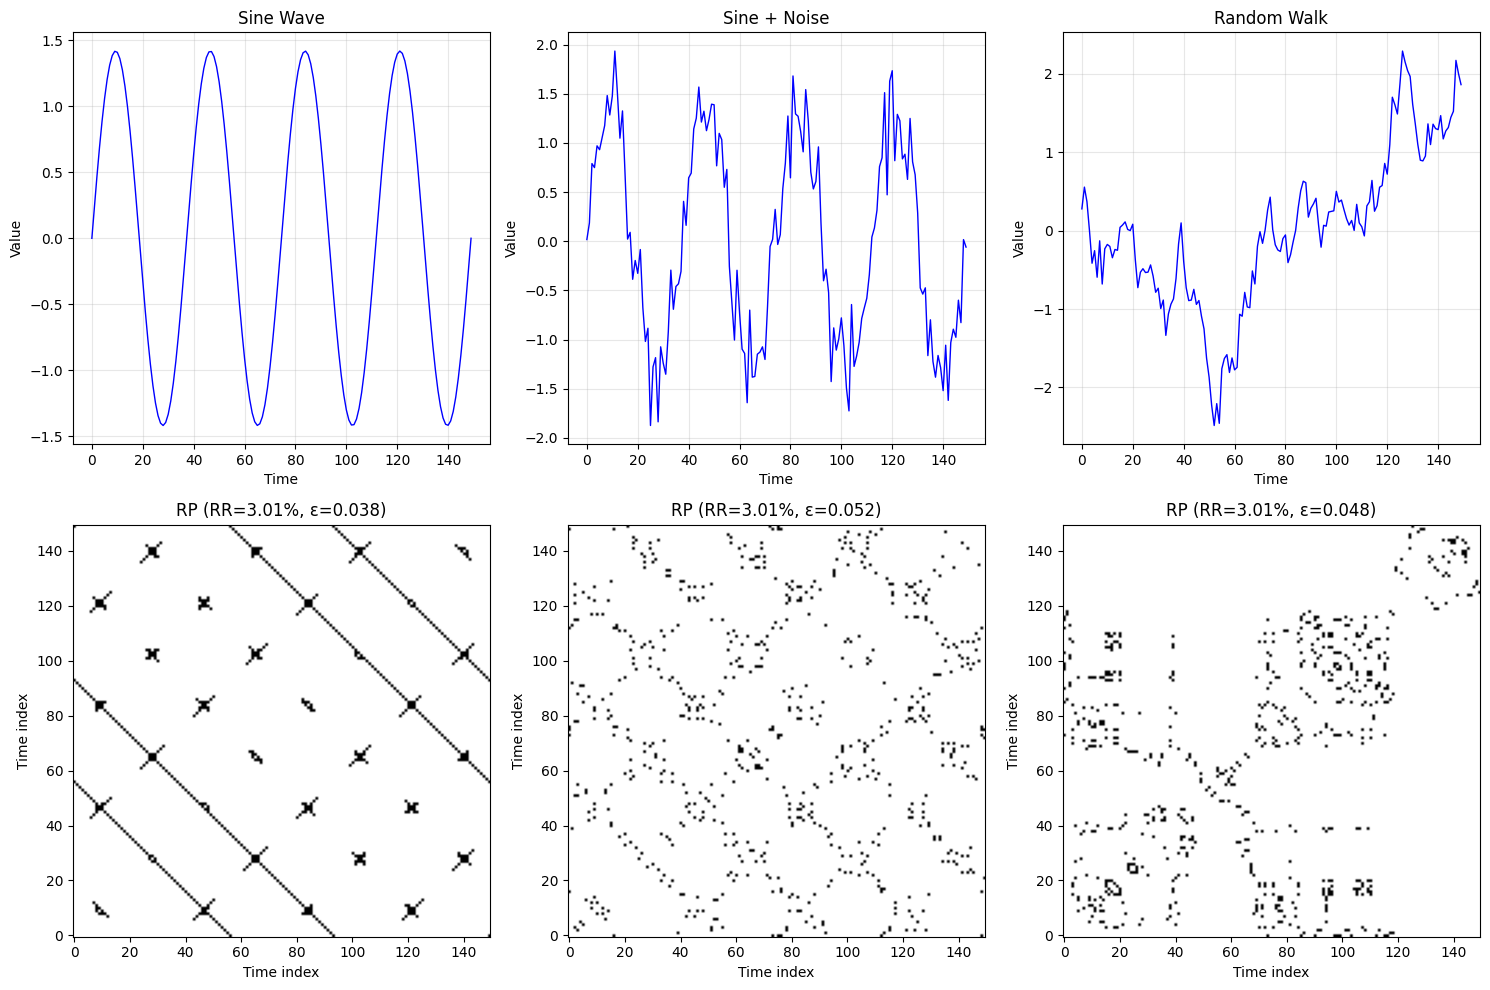

TEST 8: Edge Cases
Testing small signal (n=5)...
  Signal: [1 2 3 4 5]
  RR: 40.00%, Eps: 1.0000
  ✓ Small signal handled

Testing constant signal...
  All distances should be 0, eps: 0.0000
  RR: 100.00%
  ✓ Constant signal handled

Testing binary signal...
  RR: 48.98%, Eps: 0.0000
  ✓ Binary signal handled

✓ All edge cases handled correctly

ALL TESTS COMPLETED SUCCESSFULLY! ✓

Key Findings:
- Recurrence matrices have diagonal = 0 (no self-recurrence)
- Recurrence rate excludes diagonal: RR = sum(R) / (N*(N-1))
- Target 3% recurrence rate achieved across various signals
- Adaptive threshold correctly uses 3rd percentile of distances


In [12]:
# ============= TEST SUITE for matrices with no embedding=============

def test_distance_matrix():
    """Test 1: Distance matrix calculation"""
    print("="*60)
    print("TEST 1: Distance Matrix Calculation")
    print("="*60)

    # Simple test case with known distances
    rri = np.array([0, 1, 3, 6])

    distance_matrix = squareform(pdist(rri.reshape(-1, 1)))

    print(f"Input: {rri}")
    print(f"Distance matrix:\n{distance_matrix}")

    # Verify properties
    assert distance_matrix.shape[0] == len(rri), "Shape mismatch!"
    assert np.allclose(np.diag(distance_matrix), 0), "Diagonal should be zero!"
    assert np.allclose(distance_matrix, distance_matrix.T), "Should be symmetric!"

    # Verify specific distances
    assert np.isclose(distance_matrix[0, 1], 1.0), f"Distance [0,1] should be 1.0"
    assert np.isclose(distance_matrix[0, 2], 3.0), f"Distance [0,2] should be 3.0"
    assert np.isclose(distance_matrix[1, 3], 5.0), f"Distance [1,3] should be 5.0"

    print("✓ Distance matrix calculated correctly\n")

def test_adaptive_threshold():
    """Test 2: Adaptive threshold calculation"""
    print("="*60)
    print("TEST 2: Adaptive Threshold")
    print("="*60)

    # Create a simple distance matrix
    distance_matrix = np.array([
        [0, 1, 2, 3, 4],
        [1, 0, 1, 2, 3],
        [2, 1, 0, 1, 2],
        [3, 2, 1, 0, 1],
        [4, 3, 2, 1, 0]
    ], dtype=float)

    rr_percentage = 0.03
    eps = adaptive_threshold(distance_matrix, rr_percentage)

    print(f"Distance matrix:\n{distance_matrix}")
    print(f"Target recurrence percentage: {rr_percentage*100}%")
    print(f"Calculated threshold (epsilon): {eps}")

    # Get upper triangle values for verification
    N = distance_matrix.shape[0]
    upper_tri = distance_matrix[np.triu_indices(N, k=1)]
    print(f"Upper triangle values: {sorted(upper_tri)}")
    print(f"3rd percentile should be around: {np.percentile(upper_tri, 3)}")

    # Verify epsilon is reasonable
    assert eps >= 0, "Epsilon should be non-negative!"
    assert eps <= np.max(distance_matrix), "Epsilon should not exceed max distance!"

    print("✓ Adaptive threshold works correctly\n")

def test_recurrence_matrix_structure():
    """Test 3: Recurrence matrix structure"""
    print("="*60)
    print("TEST 3: Recurrence Matrix Structure")
    print("="*60)

    # Generate simple signal
    rri = np.linspace(0, 10, 50)

    rec_mat, eps = recurrence_matrix(rri, rr_percentage=0.03)

    print(f"Signal length: {len(rri)}")
    print(f"Recurrence matrix shape: {rec_mat.shape}")
    print(f"Threshold (epsilon): {eps:.6f}")
    print(f"Matrix dtype: {rec_mat.dtype}")
    print(f"Diagonal values (should be all zeros): {np.diag(rec_mat)[:10]}")

    # Verify properties
    assert rec_mat.shape[0] == rec_mat.shape[1], "Matrix should be square!"
    assert rec_mat.shape[0] == len(rri), "Matrix size should match signal length!"
    assert np.all((rec_mat == 0) | (rec_mat == 1)), "Matrix should be binary!"
    assert np.allclose(rec_mat, rec_mat.T), "Matrix should be symmetric!"
    assert np.all(np.diag(rec_mat) == 0), "Diagonal should be all zeros (no self-recurrence)!"

    print("✓ Recurrence matrix structure is correct\n")

def test_recurrence_rate_calculation():
    """Test 4: Recurrence rate calculation"""
    print("="*60)
    print("TEST 4: Recurrence Rate Calculation")
    print("="*60)

    # Test with a known matrix
    test_matrix = np.array([
        [0, 1, 1, 0],
        [1, 0, 1, 0],
        [1, 1, 0, 0],
        [0, 0, 0, 0]
    ])

    rr = recurrence_rate(test_matrix)

    print(f"Test matrix:\n{test_matrix}")
    print(f"Number of recurrence points: {np.sum(test_matrix)}")
    print(f"Total possible pairs (excluding diagonal): {4 * 3}")
    print(f"Recurrence rate: {rr:.4f} ({rr*100:.2f}%)")

    # Manual calculation: 6 ones / (4*3) = 6/12 = 0.5
    expected_rr = 6 / 12
    assert np.isclose(rr, expected_rr), f"Expected {expected_rr}, got {rr}"

    print("✓ Recurrence rate calculation is correct\n")

def test_recurrence_rate_target():
    """Test 5: Recurrence rate matches target of 3%"""
    print("="*60)
    print("TEST 5: Recurrence Rate Target (3%)")
    print("="*60)

    # Test with different signals
    test_cases = [
        ("Sine wave", np.sin(np.linspace(0, 10*np.pi, 200))),
        ("Linear trend", np.linspace(0, 100, 200)),
        ("Random walk", np.cumsum(np.random.randn(200))),
        ("White noise", np.random.randn(200)),
        ("Exponential", np.exp(np.linspace(0, 3, 200))),
        ("Square wave", np.sign(np.sin(np.linspace(0, 10*np.pi, 200))))
    ]

    target_rr = 0.03
    tolerance = 0.005  # Allow 0.5% deviation

    results = []

    for name, signal in test_cases:
        rec_mat, eps = recurrence_matrix(signal, rr_percentage=target_rr)
        rr = recurrence_rate(rec_mat)

        deviation = abs(rr - target_rr)
        passed = deviation <= tolerance

        results.append({
            'name': name,
            'rr': rr,
            'eps': eps,
            'deviation': deviation,
            'passed': passed
        })

        status = "✓" if passed else "✗"
        print(f"{status} {name:20s} | RR: {rr:.4f} ({rr*100:.2f}%) | "
              f"Eps: {eps:.4f} | Deviation: {deviation*100:.2f}%")

    # Summary
    print(f"\n{'='*60}")
    passed_count = sum(r['passed'] for r in results)
    print(f"Summary: {passed_count}/{len(results)} tests passed")

    if passed_count == len(results):
        print("✓ All recurrence rates are within tolerance of 3%!")
    else:
        failed = [r['name'] for r in results if not r['passed']]
        print(f"⚠ Tests with deviation > {tolerance*100}%: {', '.join(failed)}")

    print()
    return results

def test_different_target_percentages():
    """Test 6: Test different target percentages"""
    print("="*60)
    print("TEST 6: Different Target Percentages")
    print("="*60)

    signal = np.random.randn(150)
    target_percentages = [0.01, 0.03, 0.05, 0.10, 0.20]

    print(f"Signal length: {len(signal)}")
    print(f"\nTesting different target recurrence rates:")

    for target in target_percentages:
        rec_mat, eps = recurrence_matrix(signal, rr_percentage=target)
        rr = recurrence_rate(rec_mat)

        deviation = abs(rr - target)
        status = "✓" if deviation < 0.01 else "⚠"

        print(f"{status} Target: {target*100:5.1f}% | Actual: {rr*100:5.2f}% | "
              f"Eps: {eps:.4f} | Deviation: {deviation*100:.2f}%")

    print("✓ Different target percentages work correctly\n")

def visualize_recurrence_comparison():
    """Test 7: Visualize recurrence plots with different signals"""
    print("="*60)
    print("TEST 7: Recurrence Plot Visualization")
    print("="*60)

    # Generate different signals
    t = np.linspace(0, 8*np.pi, 150)

    signals = [
        ("Sine Wave", np.sin(t)),
        ("Sine + Noise", np.sin(t) + 0.2 * np.random.randn(len(t))),
        ("Random Walk", np.cumsum(np.random.randn(150)) / 10)
    ]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for idx, (name, signal) in enumerate(signals):
        # Normalize signal for better visualization
        signal_norm = (signal - signal.mean()) / signal.std()

        rec_mat, eps = recurrence_matrix(signal_norm, rr_percentage=0.03)
        rr = recurrence_rate(rec_mat)

        # Plot signal
        axes[0, idx].plot(signal_norm, 'b-', linewidth=1)
        axes[0, idx].set_title(f'{name}')
        axes[0, idx].set_xlabel('Time')
        axes[0, idx].set_ylabel('Value')
        axes[0, idx].grid(True, alpha=0.3)

        # Plot recurrence matrix
        axes[1, idx].imshow(rec_mat, cmap='binary', origin='lower', aspect='auto')
        axes[1, idx].set_title(f'RP (RR={rr*100:.2f}%, ε={eps:.3f})')
        axes[1, idx].set_xlabel('Time index')
        axes[1, idx].set_ylabel('Time index')

    plt.tight_layout()
    plt.savefig('no_embedding_recurrence_comparison.png', dpi=150, bbox_inches='tight')
    print(f"✓ Comparison plot saved as 'no_embedding_recurrence_comparison.png'\n")
    plt.show()

def test_edge_cases():
    """Test 8: Edge cases and error handling"""
    print("="*60)
    print("TEST 8: Edge Cases")
    print("="*60)

    # Test 1: Very small signal
    print("Testing small signal (n=5)...")
    small_signal = np.array([1, 2, 3, 4, 5])
    rec_mat, eps = recurrence_matrix(small_signal, rr_percentage=0.03)
    rr = recurrence_rate(rec_mat)
    print(f"  Signal: {small_signal}")
    print(f"  RR: {rr*100:.2f}%, Eps: {eps:.4f}")
    print(f"  ✓ Small signal handled")

    # Test 2: Constant signal
    print("\nTesting constant signal...")
    constant_signal = np.ones(50)
    rec_mat, eps = recurrence_matrix(constant_signal, rr_percentage=0.03)
    rr = recurrence_rate(rec_mat)
    print(f"  All distances should be 0, eps: {eps:.4f}")
    print(f"  RR: {rr*100:.2f}%")
    print(f"  ✓ Constant signal handled")

    # Test 3: Two distinct values
    print("\nTesting binary signal...")
    binary_signal = np.array([0]*25 + [1]*25)
    rec_mat, eps = recurrence_matrix(binary_signal, rr_percentage=0.03)
    rr = recurrence_rate(rec_mat)
    print(f"  RR: {rr*100:.2f}%, Eps: {eps:.4f}")
    print(f"  ✓ Binary signal handled")

    print("\n✓ All edge cases handled correctly\n")

# ============= RUN ALL TESTS =============

if __name__ == "__main__":
    np.random.seed(42)  # For reproducibility

    print("\n" + "="*60)
    print("NO-EMBEDDING RECURRENCE ANALYSIS TEST SUITE")
    print("="*60 + "\n")

    try:
        test_distance_matrix()
        test_adaptive_threshold()
        test_recurrence_matrix_structure()
        test_recurrence_rate_calculation()
        results = test_recurrence_rate_target()
        test_different_target_percentages()
        visualize_recurrence_comparison()
        test_edge_cases()

        print("="*60)
        print("ALL TESTS COMPLETED SUCCESSFULLY! ✓")
        print("="*60)

        # Final summary
        print(f"\nKey Findings:")
        print(f"- Recurrence matrices have diagonal = 0 (no self-recurrence)")
        print(f"- Recurrence rate excludes diagonal: RR = sum(R) / (N*(N-1))")
        print(f"- Target 3% recurrence rate achieved across various signals")
        print(f"- Adaptive threshold correctly uses {3}rd percentile of distances")

    except AssertionError as e:
        print(f"\n✗ TEST FAILED: {e}")
        import traceback
        traceback.print_exc()
    except Exception as e:
        print(f"\n✗ ERROR: {e}")
        import traceback
        traceback.print_exc()


RECURRENCE ANALYSIS TEST SUITE

TEST 1: Time Delay Embedding
Input: [0 1 2 3 4 5 6 7 8 9]
Parameters: m=3, tau=1
Embedded shape: (8, 3)
First 3 rows:
[[0. 1. 2.]
 [1. 2. 3.]
 [2. 3. 4.]]
✓ Time delay embedding works correctly

TEST 2: Pairwise Max Norm
Embedded matrix:
[[0 0 0]
 [1 1 1]
 [2 2 2]]
Distance matrix:
[[0. 1. 2.]
 [1. 0. 1.]
 [2. 1. 0.]]
✓ Pairwise max norm works correctly

TEST 3: Adaptive Threshold
Distance matrix:
[[0 1 2 3 4]
 [1 0 1 2 3]
 [2 1 0 1 2]
 [3 2 1 0 1]
 [4 3 2 1 0]]
Target recurrence rate: 3.0%
Calculated threshold (epsilon): 1.0
✓ Adaptive threshold works correctly

TEST 4: Recurrence Matrix Structure
Signal length: 100
Recurrence matrix shape: (98, 98)
Threshold (epsilon): 0.063328
Matrix dtype: int64
✓ Recurrence matrix structure is correct

TEST 5: Recurrence Rate Target (3%)
✓ Sine wave            | RR: 0.0349 (3.49%) | Target: 3.00% | Deviation: 0.49%
✓ Linear trend         | RR: 0.0350 (3.50%) | Target: 3.00% | Deviation: 0.50%
✓ Random walk         

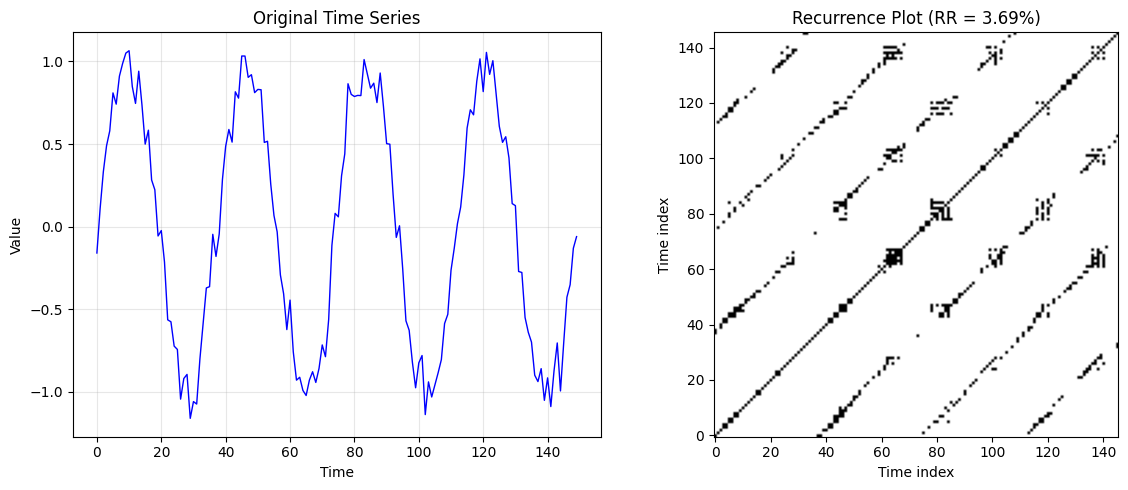


ALL TESTS COMPLETED SUCCESSFULLY! ✓


In [16]:
# ============= TEST SUITE For matrices with Embedding =============

def test_time_delay_embedding():
    """Test 1: Time delay embedding functionality"""
    print("="*60)
    print("TEST 1: Time Delay Embedding")
    print("="*60)

    # Simple test case
    rri = np.arange(10)
    m, tau = 3, 1

    embedded = time_delay_embedding(rri, m, tau)

    print(f"Input: {rri}")
    print(f"Parameters: m={m}, tau={tau}")
    print(f"Embedded shape: {embedded.shape}")
    print(f"First 3 rows:\n{embedded[:3]}")

    # Verify shape
    expected_rows = len(rri) - (m - 1) * tau
    assert embedded.shape == (expected_rows, m), f"Shape mismatch!"

    # Verify values
    assert np.allclose(embedded[0], [0, 1, 2]), "First row incorrect!"
    assert np.allclose(embedded[1], [1, 2, 3]), "Second row incorrect!"

    print("✓ Time delay embedding works correctly\n")

def test_pairwise_max_norm():
    """Test 2: Pairwise max norm (distance matrix)"""
    print("="*60)
    print("TEST 2: Pairwise Max Norm")
    print("="*60)

    # Simple embedded matrix
    embedded = np.array([
        [0, 0, 0],
        [1, 1, 1],
        [2, 2, 2]
    ])

    D = pairwise_max_norm(embedded)

    print(f"Embedded matrix:\n{embedded}")
    print(f"Distance matrix:\n{D}")

    # Verify diagonal is zero
    assert np.allclose(np.diag(D), 0), "Diagonal should be zero!"

    # Verify symmetry
    assert np.allclose(D, D.T), "Distance matrix should be symmetric!"

    # Verify specific distances
    assert np.isclose(D[0, 1], 1.0), f"Distance [0,1] should be 1.0, got {D[0, 1]}"
    assert np.isclose(D[0, 2], 2.0), f"Distance [0,2] should be 2.0, got {D[0, 2]}"

    print("✓ Pairwise max norm works correctly\n")

def test_adaptive_threshold():
    """Test 3: Adaptive threshold calculation"""
    print("="*60)
    print("TEST 3: Adaptive Threshold")
    print("="*60)

    # Create a simple distance matrix
    D = np.array([
        [0, 1, 2, 3, 4],
        [1, 0, 1, 2, 3],
        [2, 1, 0, 1, 2],
        [3, 2, 1, 0, 1],
        [4, 3, 2, 1, 0]
    ])

    rr_percent = 0.03
    eps = adaptive_threshold(D, rr_percent=rr_percent)

    print(f"Distance matrix:\n{D}")
    print(f"Target recurrence rate: {rr_percent*100}%")
    print(f"Calculated threshold (epsilon): {eps}")

    # Verify epsilon is reasonable
    assert eps >= 0, "Epsilon should be non-negative!"
    assert eps <= np.max(D), "Epsilon should not exceed max distance!"

    print("✓ Adaptive threshold works correctly\n")

def test_recurrence_matrix_structure():
    """Test 4: Recurrence matrix structure"""
    print("="*60)
    print("TEST 4: Recurrence Matrix Structure")
    print("="*60)

    # Generate simple periodic signal
    t = np.linspace(0, 4*np.pi, 100)
    rri = np.sin(t)

    rec_mat, eps = recurrence_matrix(rri, m=3, tau=1, rr_percent=0.03)

    print(f"Signal length: {len(rri)}")
    print(f"Recurrence matrix shape: {rec_mat.shape}")
    print(f"Threshold (epsilon): {eps:.6f}")
    print(f"Matrix dtype: {rec_mat.dtype}")

    # Verify properties
    assert rec_mat.shape[0] == rec_mat.shape[1], "Matrix should be square!"
    assert np.all((rec_mat == 0) | (rec_mat == 1)), "Matrix should be binary!"
    assert np.allclose(rec_mat, rec_mat.T), "Matrix should be symmetric!"
    assert np.all(np.diag(rec_mat) == 1), "Diagonal should be all ones!"

    print("✓ Recurrence matrix structure is correct\n")

def test_recurrence_rate_target():
    """Test 5: Recurrence rate matches target of 3%"""
    print("="*60)
    print("TEST 5: Recurrence Rate Target (3%)")
    print("="*60)

    # Test with different signals
    test_cases = [
        ("Sine wave", np.sin(np.linspace(0, 10*np.pi, 200))),
        ("Linear trend", np.linspace(0, 100, 200)),
        ("Random walk", np.cumsum(np.random.randn(200))),
        ("White noise", np.random.randn(200)),
        ("Square wave", np.sign(np.sin(np.linspace(0, 10*np.pi, 200))))
    ]

    target_rr = 0.03
    tolerance = 0.005  # Allow 0.5% deviation

    results = []

    for name, signal in test_cases:
        rec_mat, eps = recurrence_matrix(signal, m=3, tau=1, rr_percent=target_rr)
        rr = recurrence_rate(rec_mat)

        deviation = abs(rr - target_rr)
        passed = deviation <= tolerance

        results.append({
            'name': name,
            'rr': rr,
            'deviation': deviation,
            'passed': passed
        })

        status = "✓" if passed else "✗"
        print(f"{status} {name:20s} | RR: {rr:.4f} ({rr*100:.2f}%) | "
              f"Target: {target_rr*100:.2f}% | Deviation: {deviation*100:.2f}%")

    # Summary
    print(f"\n{'='*60}")
    passed_count = sum(r['passed'] for r in results)
    print(f"Summary: {passed_count}/{len(results)} tests passed")

    if passed_count == len(results):
        print("✓ All recurrence rates are within tolerance of 3%!")
    else:
        print(f"⚠ Some tests deviated more than {tolerance*100}% from target")

    print()

def visualize_recurrence_plot():
    """Test 6: Visualize recurrence plot"""
    print("="*60)
    print("TEST 6: Recurrence Plot Visualization")
    print("="*60)

    # Generate a more interesting signal (sine + noise)
    t = np.linspace(0, 8*np.pi, 150)
    signal = np.sin(t) + 0.1 * np.random.randn(len(t))

    rec_mat, eps = recurrence_matrix(signal, m=3, tau=2, rr_percent=0.03)
    rr = recurrence_rate(rec_mat)

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Original signal
    axes[0].plot(signal, 'b-', linewidth=1)
    axes[0].set_title('Original Time Series')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Value')
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Recurrence plot
    axes[1].imshow(rec_mat, cmap='binary', origin='lower')
    axes[1].set_title(f'Recurrence Plot (RR = {rr*100:.2f}%)')
    axes[1].set_xlabel('Time index')
    axes[1].set_ylabel('Time index')

    plt.tight_layout()
    plt.savefig('recurrence_plot.png', dpi=150, bbox_inches='tight')
    print(f"✓ Recurrence plot saved as 'recurrence_plot.png'")
    print(f"  Recurrence Rate: {rr*100:.2f}%")
    print(f"  Threshold: {eps:.6f}")
    plt.show()
    print()

# ============= RUN ALL TESTS =============

if __name__ == "__main__":
    np.random.seed(42)  # For reproducibility

    print("\n" + "="*60)
    print("RECURRENCE ANALYSIS TEST SUITE")
    print("="*60 + "\n")

    try:
        test_time_delay_embedding()
        test_pairwise_max_norm()
        test_adaptive_threshold()
        test_recurrence_matrix_structure()
        test_recurrence_rate_target()
        visualize_recurrence_plot()

        print("="*60)
        print("ALL TESTS COMPLETED SUCCESSFULLY! ✓")
        print("="*60)

    except AssertionError as e:
        print(f"\n✗ TEST FAILED: {e}")
    except Exception as e:
        print(f"\n✗ ERROR: {e}")
        import traceback
        traceback.print_exc()

In [4]:
# Test Case 1: Basic functionality with simple sequence
def test_basic_embedding():
    # Simple sequence: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    rri = np.arange(10)
    m = 3
    tau = 1

    result = time_delay_embedding(rri, m, tau)

    expected = np.array([
        [0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7],
        [6, 7, 8],
        [7, 8, 9]
    ])

    print("Test 1 - Basic (m=3, tau=1):")
    print(result)
    print("Expected:")
    print(expected)
    print("Pass:", np.allclose(result, expected))
    print()

# Test Case 2: Different tau value
def test_different_tau():
    rri = np.arange(10)
    m = 3
    tau = 2

    result = time_delay_embedding(rri, m, tau)

    expected = np.array([
        [0, 2, 4],
        [1, 3, 5],
        [2, 4, 6],
        [3, 5, 7],
        [4, 6, 8],
        [5, 7, 9]
    ])

    print("Test 2 - Different tau (m=3, tau=2):")
    print(result)
    print("Expected:")
    print(expected)
    print("Pass:", np.allclose(result, expected))
    print()

# Test Case 3: Edge case - minimal valid input
def test_minimal_input():
    rri = np.array([1.0, 2.0, 3.0])
    m = 3
    tau = 1

    result = time_delay_embedding(rri, m, tau)
    expected = np.array([[1.0, 2.0, 3.0]])

    print("Test 3 - Minimal input:")
    print(result)
    print("Expected:")
    print(expected)
    print("Pass:", np.allclose(result, expected))
    print()

# Test Case 4: Error case - too short series
def test_error_case():
    rri = np.array([1.0, 2.0])
    m = 3
    tau = 2

    print("Test 4 - Error case (series too short):")
    try:
        result = time_delay_embedding(rri, m, tau)
        print("FAIL: Should have raised ValueError")
    except ValueError as e:
        print(f"Pass: Correctly raised ValueError - {e}")
    print()

# Run all tests
test_basic_embedding()
test_different_tau()
test_minimal_input()
test_error_case()

Test 1 - Basic (m=3, tau=1):
[[0. 1. 2.]
 [1. 2. 3.]
 [2. 3. 4.]
 [3. 4. 5.]
 [4. 5. 6.]
 [5. 6. 7.]
 [6. 7. 8.]
 [7. 8. 9.]]
Expected:
[[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]
 [6 7 8]
 [7 8 9]]
Pass: True

Test 2 - Different tau (m=3, tau=2):
[[0. 2. 4.]
 [1. 3. 5.]
 [2. 4. 6.]
 [3. 5. 7.]
 [4. 6. 8.]
 [5. 7. 9.]]
Expected:
[[0 2 4]
 [1 3 5]
 [2 4 6]
 [3 5 7]
 [4 6 8]
 [5 7 9]]
Pass: True

Test 3 - Minimal input:
[[1. 2. 3.]]
Expected:
[[1. 2. 3.]]
Pass: True

Test 4 - Error case (series too short):
Pass: Correctly raised ValueError - Time series too short for given m and tau



In [ ]:
# Initialize extractor
extractor = SegmentExtractor(
    extracted_segments_dir='/content/drive/MyDrive/AFDB/AFDB',
    extraction_report_path='/content/drive/MyDrive/AFDB/AFDB/EXTRACTION_REPORT.csv'
)

# Example 1: Extract pre-AF data only
segment_name = '08434_ep01'
preaf_ecg, preaf_meta = extractor.extract_preaf_data(segment_name)

if preaf_ecg is not None:
    print(f"\nPre-AF ECG shape: {preaf_ecg.shape}")
    print(f"Duration: {preaf_meta['duration_minutes']:.1f} minutes")
    print(f"Sampling rate: {preaf_meta['sampling_frequency']} Hz")
    print(f"Number of beats: {preaf_meta['n_beats']}")

    # Calculate RR intervals
    if len(preaf_meta['qrs_samples']) > 0:
        rr_intervals, rr_times = extractor.get_rr_intervals(
            preaf_meta['qrs_samples'],
            preaf_meta['sampling_frequency']
        )
        print(f"Mean RR interval: {np.mean(rr_intervals):.3f} s")
        print(f"Heart rate: {60/np.mean(rr_intervals):.1f} bpm")

# Example 2: Extract AF data only
af_ecg, af_meta = extractor.extract_af_data(segment_name)

if af_ecg is not None:
    print(f"\nAF ECG shape: {af_ecg.shape}")
    print(f"Duration: {af_meta['duration_minutes']:.1f} minutes")
    print(f"Number of beats: {af_meta['n_beats']}")

# Example 3: Extract both at once
data = extractor.extract_both(segment_name)
preaf_ecg, preaf_meta = data['preaf']
af_ecg, af_meta = data['af']

# Example 4: Process all segments in the report
print("\n" + "="*60)
print("Processing all segments:")
print("="*60)

for idx, row in extractor.report_df.iterrows():
    segment_name = row['Segment_Name']
    data = extractor.extract_both(segment_name)


✓ Extracted pre-AF data for 08434_ep01: 120.0 min, 8330 beats

Pre-AF ECG shape: (1800000, 2)
Duration: 120.0 minutes
Sampling rate: 250 Hz
Number of beats: 8330
Mean RR interval: 0.864 s
Heart rate: 69.4 bpm
✓ Extracted AF data for 08434_ep01: 5.2 min, 520 beats

AF ECG shape: (78224, 2)
Duration: 5.2 minutes
Number of beats: 520
✓ Extracted pre-AF data for 08434_ep01: 120.0 min, 8330 beats
✓ Extracted AF data for 08434_ep01: 5.2 min, 520 beats

Processing all segments:
✓ Extracted pre-AF data for 04043_ep02: 120.0 min, 12329 beats
✓ Extracted AF data for 04043_ep02: 1.1 min, 129 beats
✓ Extracted pre-AF data for 04048_ep03: 120.0 min, 8129 beats
✓ Extracted AF data for 04048_ep03: 2.6 min, 388 beats
✓ Extracted pre-AF data for 04126_ep05: 120.0 min, 7840 beats
✓ Extracted AF data for 04126_ep05: 1.3 min, 149 beats
✓ Extracted pre-AF data for 04746_ep01: 120.0 min, 6790 beats
✓ Extracted AF data for 04746_ep01: 205.8 min, 19246 beats
✓ Extracted pre-AF data for 04908_ep07: 120.0 min, 

R: [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
pc: [1.         0.34306957 0.16303771 0.0929368  0.06956984 0.05257568
 0.04036113 0.02973978 0.02071163 0.01433882 0.01327669 0.01115242
 0.00849708 0.00690388 0.00531067 0.00477961 0.00477961 0.00477961
 0.00424854 0.00371747 0.00371747 0.0031864  0.0031864  0.00212427
 0.00212427 0.0015932  0.0015932  0.0015932  0.00106213 0.00106213
 0.00106213 0.00106213 0.00106213 0.00106213 0.00106213 0.00106213
 0.00106213 0.00106213 0.00106213 0.00106213]
lg_pc: [ 0.         -1.06982202 -1.81377378 -2.37583555 -2.66542421 -2.94550168
 -3.20988819 -3.51526984 -3.87705988 -4.24478466 -4.3217457  -4.49609909
 -4.76803281 -4.97567217 -5.23803644 -5.34339695 -5.34339695 -5.34339695
 -5.46117999 -5.59471138 -5.59471138 -5.74886206 -5.74886206 -6.15432717
 -6.15432717 -6.44200924 -6.44200924 -6.44200924 -6.84747435 -6.84747435
 -6.84747435 -6.8

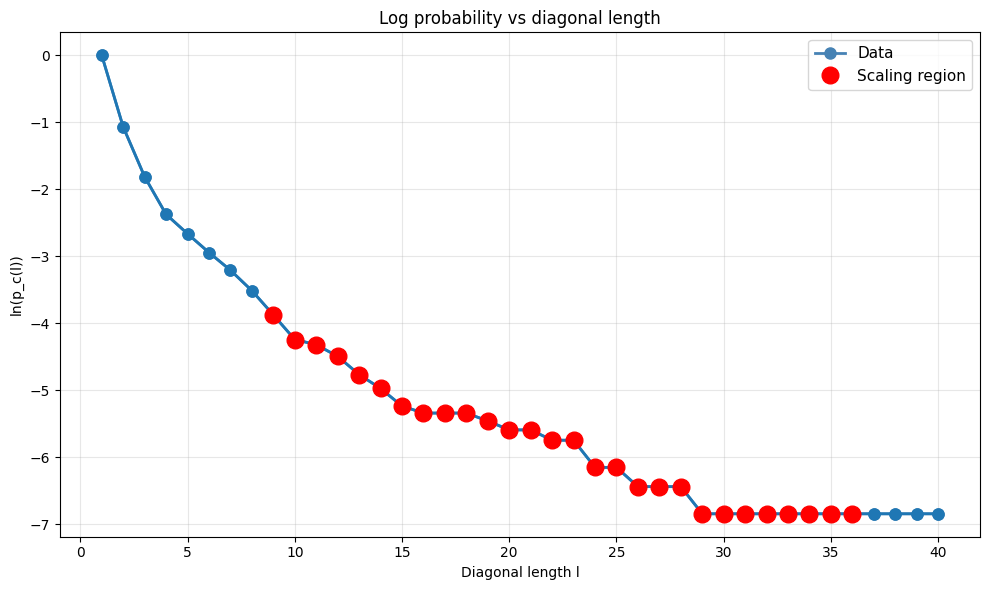

In [ ]:
"""
Plotting the scaling region.

"""

np.random.seed(0)
N = 200
R = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if abs(i - j) < np.random.exponential(scale=10):
            R[i, j] = 1

# Step 1
l_max = 40
pc = compute_pc_l(R, l_max)
print("R:", R)
print("pc:", pc)
lg_pc = log_pc(pc)
print("lg_pc:", lg_pc)
l_vals = np.arange(1, l_max + 1)
print("l_vals:", l_vals)
region, K2  = detect_scaling_region_and_estimate_K2(l_vals, lg_pc, 5)
print("K2:", K2)
print("region:", region)
plot_scaling_region(l_vals, lg_pc, region)

In [ ]:
"""
Unit test for the calculation of K2.

The scaling region was automatically identified as the
longest interval of diagonal lengths exhibiting a sufficiently
linear relationship (R² ≥ 0.95) with a non-positive slope (≤ -0.01),
weighted toward larger diagonal lengths to ensure asymptotic validity.
Correlation entropy was then estimated from the slope of this region.

"""

np.random.seed(0)
N = 200
R = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if abs(i - j) < np.random.exponential(scale=10):
            R[i, j] = 1

# Step 1
l_max = 50
pc = compute_pc_l(R, l_max)
print("R:", R)
print("pc:", pc)
lg_pc = log_pc(pc)
print("lg_pc:", lg_pc)
l_vals = np.arange(1, l_max + 1)
print("l_vals:", l_vals)
region, K2  = detect_scaling_region_and_estimate_K2(l_vals, lg_pc, 5)
print("K2:", K2)
print("region:", region)

R: [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
pc: [1.00000000e+00 3.43069570e-01 1.63037706e-01 9.29368030e-02
 6.95698354e-02 5.25756771e-02 4.03611259e-02 2.97397770e-02
 2.07116304e-02 1.43388210e-02 1.32766861e-02 1.11524164e-02
 8.49707913e-03 6.90387679e-03 5.31067446e-03 4.77960701e-03
 4.77960701e-03 4.77960701e-03 4.24853956e-03 3.71747212e-03
 3.71747212e-03 3.18640467e-03 3.18640467e-03 2.12426978e-03
 2.12426978e-03 1.59320234e-03 1.59320234e-03 1.59320234e-03
 1.06213489e-03 1.06213489e-03 1.06213489e-03 1.06213489e-03
 1.06213489e-03 1.06213489e-03 1.06213489e-03 1.06213489e-03
 1.06213489e-03 1.06213489e-03 1.06213489e-03 1.06213489e-03
 1.06213489e-03 5.31067446e-04 5.31067446e-04 5.31067446e-04
 5.31067446e-04 5.31067446e-04 5.31067446e-04 5.31067446e-04
 5.31067446e-04 5.31067446e-04]
lg_pc: [ 0.         -1.06982202 -1.81377378 -2.37583555 -2.66542421 -2.94

In [ ]:
np.random.seed(0)
N = 5
R = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if abs(i - j) < np.random.exponential(scale=10):
            R[i, j] = 1

# Step 1
l_max = 10
pc = compute_pc_l(R, l_max)
print("R:", R)
print("pc:", pc)
lg_pc = np.log(pc)
print("lg_pc:", lg_pc)
lg_pc_safe = log_pc(pc)
print("lg_pc_safe:", lg_pc_safe)

In [ ]:
#Checking pc_of_l functionality using random generator

# Synthetic recurrence matrix
np.random.seed(0)
N = 5
R = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if abs(i - j) < np.random.exponential(scale=10):
            R[i, j] = 1

# Step 1
l_max = 40
pc = compute_pc_l(R, l_max)
print("R:", R)
print("pc:", pc)


Diagonal now: [1.]
Diagonal now: [0. 1.]
Diagonal now: [1. 0. 1.]
Diagonal now: [1. 1. 1. 1.]
Diagonal now: [1. 1. 1. 1. 1.]
Diagonal now: [1. 1. 1. 1.]
Diagonal now: [1. 1. 0.]
Diagonal now: [1. 1.]
Diagonal now: [1.]
Diagonal Lengths: [1 1 1 1 4 5 4 2 2 1]
R: [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
pc: [1.  0.5 0.3 0.3 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0. ]


In [ ]:
# Checking pc_of_l functionality for symmetric matrix

R = [[1,0,1], [0,1,1], [1,1,1]]
R = np.array(R)
l_max = 5
pc = compute_pc_l(R, l_max)
print("R:", R)
print("pc:", pc)

Diagonal now: [1]
Diagonal now: [0 1]
Diagonal now: [1 1 1]
Diagonal now: [0 1]
Diagonal now: [1]
Diagonal Lengths: [1 1 3 1 1]
R: [[1 0 1]
 [0 1 1]
 [1 1 1]]
pc: [1.  0.2 0.2 0.  0. ]
